#  Bagmati catchment
# Hyperparameter tuning using model_builder function from tensorflow (Max normalization)
(After midterm)
#(https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [224]:
import numpy as np
import pandas as pd

### define file path
path = 'Non_scaled_6_input_Bagmati_yr.csv'  ####### This excel data is not scaled/normalized
## Read CSV file and convert it to dataframe
df = pd.read_csv( path, sep = ',', header = 'infer')


In [225]:
df

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.878,25.060,3.613,8.190,1.608,28.160,299.0
1,0.000,0.878,25.060,3.613,8.190,1.608,182.0
2,25.527,0.000,0.878,25.060,3.613,8.190,151.0
3,36.896,25.527,0.000,0.878,25.060,3.613,561.0
4,6.184,36.896,25.527,0.000,0.878,25.060,384.0
...,...,...,...,...,...,...,...
2909,7.115,0.422,7.130,13.781,4.314,18.381,132.0
2910,3.118,7.115,0.422,7.130,13.781,4.314,107.0
2911,61.877,3.118,7.115,0.422,7.130,13.781,538.0
2912,112.900,61.877,3.118,7.115,0.422,7.130,921.0


In [226]:
df.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000
mean,5.433136,5.434821,5.397316,5.378893,5.378374,5.385596,149.648264
std,14.030448,14.032511,13.890520,13.851130,13.851243,13.857633,271.208820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.700000
75%,4.916000,4.916000,4.864500,4.864500,4.864500,4.864500,195.975000
max,364.590000,364.590000,364.590000,364.590000,364.590000,364.590000,5030.000000


# 1. Data splitting

##  Train, Validation and Test data 
###  70% train (2040 data points)
###  15% train (436 data points)
###  15% train (436 data points)

In [227]:
df_train = df.iloc[:2040]

df_val = df.iloc[2040:2476] 

df_test = df.iloc[2476:2912] 

# 2. Normalization

In [228]:
import pandas as pd
import numpy as np

### General function for all the normalization methods

def normalize_df(data, norm_method):     

    ## Normalize data using specified method
 
    if norm_method == 'minmax':
        # Min-Max normalization
        data = (data - data.min()) / (data.max() - data.min())
    elif norm_method == 'zscore':
        # Z-score normalization
        mean = data.mean()
        std = data.std()
        data = (data - mean) / std
    elif norm_method == 'max':
        # Max normalization
        data = 1 - ((data.max() - data)/data.max())
    else:
        raise ValueError("Invalid normalization method. Choose from: 'minmax', 'zscore', 'max'")
    return data



### Max normalization  (Date sets for training, validation and testing are nromalized separately)

In [229]:
## Max normalization
df_train_norm = normalize_df(df_train, 'max')
df_val_norm = normalize_df(df_val, 'max')
df_test_norm = normalize_df(df_test, 'max')

In [230]:
###example
df_train_norm.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000
mean,0.014712,0.014746,0.014750,0.014761,0.014763,0.014801,0.030991
std,0.040109,0.040126,0.040125,0.040124,0.040123,0.040146,0.056806
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001014
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003156
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008887
75%,0.012448,0.012472,0.012472,0.012535,0.012535,0.012670,0.042346
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [231]:
### convert the dataframes to numpy arrays

df_train_f = df_train_norm.to_numpy()

df_val_f = df_val_norm.to_numpy()

df_test_f = df_test_norm.to_numpy()

In [232]:
### Define input and output sequences (list of sub sequences)

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 1    #### 5 input sequences and 2 output sequences



### Split into input and target variables

In [233]:
#### Training data


X_train, y_train = split_sequences(df_train_f, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)

# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 6

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)


(2036, 5, 6) (2036, 1)
(2036, 5, 6)


In [234]:
#### validation data

X_val, y_val = split_sequences(df_val_f , n_steps_in, n_steps_out)


X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

### reshape

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

print(X_val.shape, y_val.shape)


(432, 5, 6) (432, 1)


In [235]:
#### Test data

X_test, y_test = split_sequences(df_test_f , n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape, y_test.shape)


(432, 5, 6) (432, 1)


In [236]:
#### model fitting
import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model

from tensorflow.keras import initializers

from tensorflow.keras import layers


## Hyperparameter tuning using KerasTuner

In [237]:

import keras_tuner as kt


from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.engine.hyperparameters import Choice,Float

### a. Define model (Using model_buider function)
### (https://www.tensorflow.org/tutorials/keras/keras_tuner)
## MLP

In [238]:

def model_buider(hp):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Flatten(input_shape = (n_steps_in, n_features)))   ### flattening is important when using this function
 ###1. Tune the number of units in the first Dense layer
     
    hp_units = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    
###2. Tune the activation function

    hp_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
    
###3. Tune the weight initialization
    hp_initializer=hp.Choice('weight_init', ['he_uniform', 'glorot_uniform', 'random_normal' , 'lecun_normal'])  ##
    
   ### Fix the seeds for reproducibility purposes     
    if hp_initializer == 'he_uniform':
        init = tf.keras.initializers.he_uniform(seed=1)
    elif hp_initializer == 'glorot_uniform':
        init = tf.keras.initializers.glorot_uniform(seed=1)
    elif hp_initializer == 'random_normal':
        init = tf.keras.initializers.RandomNormal(seed=1)
    else:
        init = tf.keras.initializers.lecun_normal(seed=1)
    
###4. Tune the number of layers

    for i in range(hp.Int("num_layers", 1, 3)):
        
        model.add(keras.layers.Dense(units = hp_units, activation = hp_activation, kernel_initializer = init))
        model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
    ### Output layer
   
    model.add(keras.layers.Dense(1, kernel_initializer = init))
    model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
###4. Tune the optimizer 

    hp_optimizer = hp.Choice("optimizer", ['Adam', 'SGD', 'RMSprop'])

    model.compile (
                    optimizer = hp_optimizer, ##(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))###
                  
                    loss='mean_squared_error',
                   
                    metrics=[tf.keras.metrics.MeanSquaredError()])
    
  
    return model

    
 

### b.  Instantiate the tuner and perform hypertuning

In [239]:
#### Hyperband tuner ( it is a class)

tuner = kt.Hyperband(model_buider,
                     
                     objective= 'mean_squared_error',  ### should be the same as the loss funtion used when compiling
                     
                     max_epochs = 10,
                     
                     factor=2,  
                     
                     seed = 10,
                     
                     directory='Exhaustive_Opt_norm',
                     
                     project_name='Test1_max')

In [240]:
from keras.callbacks import TensorBoard

import datetime, os

log_dir = "Exhaustive_Opt_norm/Test1_max/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")   ### for the purpose of TensorBoard visualization


In [241]:
#tb = TensorBoard(log_dir=log_dir)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [242]:
### Create a callback to stop training early after reaching a certain value for the validation loss.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### C. Run hyperparameter search 

# 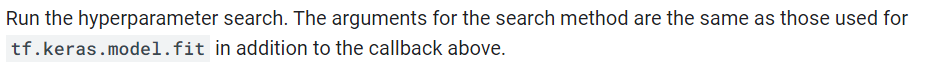

In [243]:
tuner.search(X_train, y_train, 
             epochs=200, 
             validation_data=(X_val, y_val), 
             callbacks=[stop_early,tb])

Trial 46 Complete [00h 00m 06s]
mean_squared_error: 0.0033733444288372993

Best mean_squared_error So Far: 0.0007708538323640823
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit


In [244]:
tuner.results_summary()

Results summary
Results in Exhaustive_Opt_norm\Test1_max
Showing 10 best trials
Trial summary
Hyperparameters:
units: 6
activation: tanh
weight_init: lecun_normal
num_layers: 2
dropout_rate: 0.0
optimizer: Adam
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0017
Score: 0.0007708538323640823
Trial summary
Hyperparameters:
units: 6
activation: relu
weight_init: lecun_normal
num_layers: 3
dropout_rate: 0.0
optimizer: RMSprop
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0007952058222144842
Trial summary
Hyperparameters:
units: 6
activation: tanh
weight_init: lecun_normal
num_layers: 2
dropout_rate: 0.1
optimizer: RMSprop
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.001010142033919692
Trial summary
Hyperparameters:
units: 6
activation: tanh
weight_init: lecun_normal
num_layers: 2
dropout_rate: 0.1
optimizer: RMSprop
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/ro

In [245]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [246]:
%tensorboard --logdir Exhaustive_Opt_norm/Test1_max

Reusing TensorBoard on port 6006 (pid 7156), started 1:29:37 ago. (Use '!kill 7156' to kill it.)

## d.  get the optimal hyperparameters

In [247]:

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal activation function is {best_hps.get('activation')}, the optimal weight initialization is {best_hps.get('weight_init')} and the optimal optimizer is {best_hps.get('optimizer')}.
""")




The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 6, the optimal activation function is tanh, the optimal weight initialization is lecun_normal and the optimal optimizer is Adam.



## e. Train the model using the best model

In [248]:
model = tuner.hypermodel.build(best_hps)


In [249]:
model.summary()   #### this shows us that the number of layers are 3 in this MLP model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 186       
                                                                 
 dropout_3 (Dropout)         (None, 6)                 0         
                                                                 
 dense_4 (Dense)             (None, 6)                 42        
                                                                 
 dropout_4 (Dropout)         (None, 6)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
 dropout_5 (Dropout)         (None, 1)                

In [250]:
### model training 

mlp_amt_1 = model.fit(X_train, y_train, epochs=300, validation_data = (X_val, y_val), shuffle = 0)


Epoch 1/300
64/64 [==============================] - 3s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2/300
64/64 [==============================] - 0s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/300
64/64 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/300
64/64 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 5/300
64/64 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 6/300
64/64 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 7/300
64/64 [==============

64/64 [==============================] - 0s 4ms/step - loss: 6.8583e-04 - mean_squared_error: 6.8583e-04 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 98/300
64/64 [==============================] - 0s 4ms/step - loss: 6.8565e-04 - mean_squared_error: 6.8565e-04 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 99/300
64/64 [==============================] - 0s 4ms/step - loss: 6.8546e-04 - mean_squared_error: 6.8546e-04 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 100/300
64/64 [==============================] - 0s 4ms/step - loss: 6.8528e-04 - mean_squared_error: 6.8528e-04 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 101/300
64/64 [==============================] - 0s 4ms/step - loss: 6.8510e-04 - mean_squared_error: 6.8510e-04 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 102/300
64/64 [==============================] - 0s 4ms/step - loss: 6.8492e-04 - mean_squared_error: 6.8492e-04 - val_loss: 0.0132 - val_mean_squared_erro

64/64 [==============================] - 0s 7ms/step - loss: 6.7874e-04 - mean_squared_error: 6.7874e-04 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 146/300
64/64 [==============================] - 0s 7ms/step - loss: 6.7862e-04 - mean_squared_error: 6.7862e-04 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 147/300
64/64 [==============================] - 0s 7ms/step - loss: 6.7851e-04 - mean_squared_error: 6.7851e-04 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 148/300
64/64 [==============================] - 0s 7ms/step - loss: 6.7839e-04 - mean_squared_error: 6.7839e-04 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 149/300
64/64 [==============================] - 0s 6ms/step - loss: 6.7828e-04 - mean_squared_error: 6.7828e-04 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 150/300
64/64 [==============================] - 0s 4ms/step - loss: 6.7816e-04 - mean_squared_error: 6.7816e-04 - val_loss: 0.0133 - val_mean_squared_er

Epoch 193/300
64/64 [==============================] - 0s 4ms/step - loss: 6.7390e-04 - mean_squared_error: 6.7390e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 194/300
64/64 [==============================] - 0s 4ms/step - loss: 6.7381e-04 - mean_squared_error: 6.7381e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 195/300
64/64 [==============================] - 0s 4ms/step - loss: 6.7372e-04 - mean_squared_error: 6.7372e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 196/300
64/64 [==============================] - 0s 3ms/step - loss: 6.7364e-04 - mean_squared_error: 6.7364e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 197/300
64/64 [==============================] - 0s 3ms/step - loss: 6.7355e-04 - mean_squared_error: 6.7355e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 198/300
64/64 [==============================] - 0s 3ms/step - loss: 6.7347e-04 - mean_squared_error: 6.7347e-04 - val_loss: 0.0134 - val_m

Epoch 241/300
64/64 [==============================] - 0s 3ms/step - loss: 6.7007e-04 - mean_squared_error: 6.7007e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 242/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6997e-04 - mean_squared_error: 6.6997e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 243/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6979e-04 - mean_squared_error: 6.6979e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 244/300
64/64 [==============================] - 0s 3ms/step - loss: 6.7003e-04 - mean_squared_error: 6.7003e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 245/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6979e-04 - mean_squared_error: 6.6979e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 246/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6978e-04 - mean_squared_error: 6.6978e-04 - val_loss: 0.0134 - val_m

Epoch 289/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6644e-04 - mean_squared_error: 6.6644e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 290/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6635e-04 - mean_squared_error: 6.6635e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 291/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6619e-04 - mean_squared_error: 6.6619e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 292/300
64/64 [==============================] - 0s 4ms/step - loss: 6.6622e-04 - mean_squared_error: 6.6622e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 293/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6613e-04 - mean_squared_error: 6.6613e-04 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 294/300
64/64 [==============================] - 0s 3ms/step - loss: 6.6609e-04 - mean_squared_error: 6.6609e-04 - val_loss: 0.0134 - val_m

In [251]:
#### find the best epoch by looking in to the validation loss

val_acc_per_epoch = mlp_amt_1.history['val_loss']   

#### 'val_loss' should align with the objective function used when applying 'tuner.search' (both should be loss or both accuracy)

best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 4


In [252]:
### Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model

hypermodel.fit(X_train, y_train, epochs= best_epoch, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 

# hypermodel.fit(X_train, y_train, epochs= 250, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 


Epoch 1/4
64/64 [==============================] - 1s 5ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2/4
64/64 [==============================] - 0s 3ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/4
64/64 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/4
64/64 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


## f. Test best model

In [253]:

eval_result = hypermodel.evaluate(X_test, y_test)

print("[test loss, test accuracy]:", eval_result)

14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
[test loss, test accuracy]: [0.005013878922909498, 0.005013878922909498]


In [254]:
#Y_pred = hypermodel.predict(X_test)   ### results from the hypermodel are giving fluctuating results
Y_pred = hypermodel.predict(X_test)   #### this is giving betetr result(more stable)

14/14 [==============================] - 0s 2ms/step


Y_pred

In [256]:
y_test

array([[0.00746988],
       [0.00777108],
       [0.00759036],
       [0.00740964],
       [0.00740964],
       [0.00728916],
       [0.00722892],
       [0.00704819],
       [0.00692771],
       [0.00686747],
       [0.00692771],
       [0.0089759 ],
       [0.0089759 ],
       [0.01198795],
       [0.01066265],
       [0.00987952],
       [0.00981928],
       [0.01036145],
       [0.03180723],
       [0.02524096],
       [0.01692771],
       [0.02036145],
       [0.03433735],
       [0.09439759],
       [0.08993976],
       [0.15975904],
       [0.09289157],
       [0.09403614],
       [0.09054217],
       [0.03686747],
       [0.03325301],
       [0.14572289],
       [0.08728916],
       [0.03036145],
       [0.02036145],
       [0.0213253 ],
       [0.03463855],
       [0.02433735],
       [0.01855422],
       [0.02072289],
       [0.02144578],
       [0.02253012],
       [0.08855422],
       [0.04313253],
       [0.05753012],
       [0.12012048],
       [0.13373494],
       [0.059

In [257]:
y_test.shape

(432, 1)

In [258]:
print(y_test[:,:-1].shape)   
print(y_test[:,1:2].shape)

(432, 0)
(432, 0)


In [259]:
y_test[:,-1:]    ##### all rows and all columns including -1(which is the last column)

array([[0.00746988],
       [0.00777108],
       [0.00759036],
       [0.00740964],
       [0.00740964],
       [0.00728916],
       [0.00722892],
       [0.00704819],
       [0.00692771],
       [0.00686747],
       [0.00692771],
       [0.0089759 ],
       [0.0089759 ],
       [0.01198795],
       [0.01066265],
       [0.00987952],
       [0.00981928],
       [0.01036145],
       [0.03180723],
       [0.02524096],
       [0.01692771],
       [0.02036145],
       [0.03433735],
       [0.09439759],
       [0.08993976],
       [0.15975904],
       [0.09289157],
       [0.09403614],
       [0.09054217],
       [0.03686747],
       [0.03325301],
       [0.14572289],
       [0.08728916],
       [0.03036145],
       [0.02036145],
       [0.0213253 ],
       [0.03463855],
       [0.02433735],
       [0.01855422],
       [0.02072289],
       [0.02144578],
       [0.02253012],
       [0.08855422],
       [0.04313253],
       [0.05753012],
       [0.12012048],
       [0.13373494],
       [0.059

## Evaluation metics

In [260]:
###nse

import hydroeval as he
nse = he.evaluator(he.nse, Y_pred, y_test[:,-1:]  )
print(nse)

[0.61945441]


In [261]:
##rmse
rmse = he.evaluator(he.rmse, Y_pred, y_test[:,-1:]  )
print(rmse)

[0.07080874]


In [262]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg = np.log1p(Y_pred)

#### log of test values
y_test_lg = np.log1p(y_test[:,-1:])


In [263]:
##calculate mse
mse = mean_squared_error(y_pred_lg, y_test_lg)
rmse_lg = np.sqrt(mse)   
print(rmse_lg)

0.0564358970044267


## g. plot

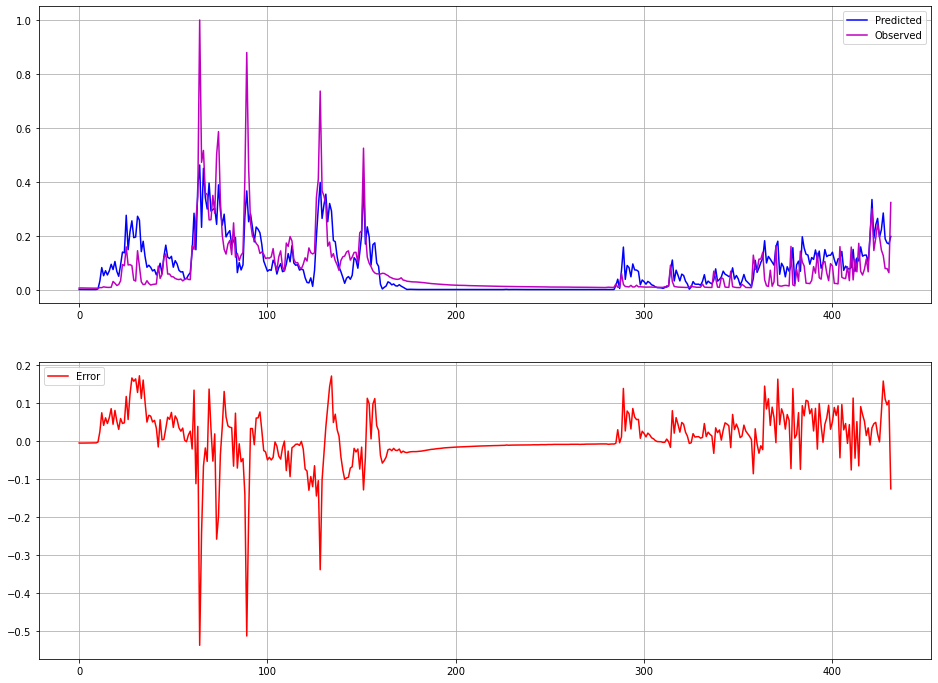

In [264]:
import matplotlib.pyplot as plt
# plt.plot(Q_pred)
# plt.plot(y_test)

plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred[:,-1],'b', label = "Predicted")

plt.plot(y_test[:,-1], 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred[:,-1] - y_test[:,-1],'r', label = "Error")

plt.legend()

plt.grid()

##  save_model

## h. Denormalize the data

In [265]:
#### Original data
df_train_norm

# df_val_f

# df_test_f

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.002408,0.068735,0.009910,0.022464,0.004410,0.077237,0.059443
1,0.000000,0.002408,0.068735,0.009910,0.022464,0.004410,0.036183
2,0.070016,0.000000,0.002408,0.068735,0.009910,0.022464,0.030020
3,0.101199,0.070016,0.000000,0.002408,0.068735,0.009910,0.111531
4,0.016962,0.101199,0.070016,0.000000,0.002408,0.068735,0.076342
...,...,...,...,...,...,...,...
2035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002883
2036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002883
2037,0.000189,0.000000,0.000000,0.000000,0.000000,0.000000,0.002883
2038,0.001588,0.000189,0.000000,0.000000,0.000000,0.000000,0.002783


In [266]:
### normalized data after model training
Y_pred    #### model out put
# y_obser = y_test[:,-1:]      ## observed discharge

array([[0.00231251],
       [0.00233212],
       [0.00218347],
       [0.00216008],
       [0.00202422],
       [0.00202422],
       [0.00202422],
       [0.00202422],
       [0.00202422],
       [0.00202422],
       [0.00417462],
       [0.03360475],
       [0.08322433],
       [0.0530329 ],
       [0.07157568],
       [0.05586318],
       [0.07110547],
       [0.0954227 ],
       [0.07581761],
       [0.10575877],
       [0.0692587 ],
       [0.05101625],
       [0.09342463],
       [0.14061023],
       [0.13792929],
       [0.276888  ],
       [0.14933991],
       [0.21618111],
       [0.25627384],
       [0.19394836],
       [0.19651484],
       [0.27323005],
       [0.2587786 ],
       [0.14215441],
       [0.18063876],
       [0.12361842],
       [0.0843957 ],
       [0.09203029],
       [0.08387324],
       [0.0707264 ],
       [0.07579294],
       [0.05606976],
       [0.07289495],
       [0.09919165],
       [0.06066527],
       [0.12445392],
       [0.16634206],
       [0.121

In [267]:
def denormalize(data, original_data, type='min_max'):   ### default is min-max in this case(there is no reason behind this)

    if type == 'min_max':
        min = np.min(original_data)
        max = np.max(original_data)
        data = data * (max - min) + min
    elif type == 'z_score':
        mean = np.mean(original_data)
        std = np.std(original_data)
        data = data * std + mean
    elif type == 'max':                
        max = np.max(original_data)
        data = data * max
    else:
        raise ValueError("Invalid normalization type. Choose either 'max', 'min_max', or 'z_score'.")
    return data

In [268]:
Y_observ_unnorm = df_test['Qt']

In [269]:
Y_observ_unnorm = Y_observ_unnorm.to_numpy()

###  denormalized predicted discharge

In [270]:
### Standard denormalization (becasue we used standard(z-score) in this experiment)

Y_pred_denorm = denormalize(Y_pred, Y_observ_unnorm, type='max')

In [271]:
print(Y_pred_denorm)
print(Y_pred_denorm.shape)

[[  3.8387706]
 [  3.8713176]
 [  3.6245527]
 [  3.5857406]
 [  3.3602116]
 [  3.3602116]
 [  3.3602116]
 [  3.3602116]
 [  3.3602116]
 [  3.3602116]
 [  6.9298754]
 [ 55.783882 ]
 [138.15239  ]
 [ 88.034615 ]
 [118.81563  ]
 [ 92.73287  ]
 [118.03509  ]
 [158.40169  ]
 [125.85723  ]
 [175.55956  ]
 [114.96945  ]
 [ 84.686966 ]
 [155.08488  ]
 [233.41298  ]
 [228.96262  ]
 [459.6341   ]
 [247.90425  ]
 [358.86066  ]
 [425.41458  ]
 [321.95428  ]
 [326.21463  ]
 [453.5619   ]
 [429.57248  ]
 [235.97632  ]
 [299.86035  ]
 [205.20659  ]
 [140.09686  ]
 [152.7703   ]
 [139.22958  ]
 [117.40583  ]
 [125.81628  ]
 [ 93.075806 ]
 [121.00561  ]
 [164.65814  ]
 [100.704346 ]
 [206.59352  ]
 [276.12784  ]
 [202.43254  ]
 [193.55707  ]
 [207.231    ]
 [140.416    ]
 [180.68402  ]
 [160.597    ]
 [121.841644 ]
 [110.87757  ]
 [112.90412  ]
 [ 68.7825   ]
 [ 70.120186 ]
 [ 91.502075 ]
 [106.9992   ]
 [237.2874   ]
 [471.9962   ]
 [247.86601  ]
 [639.80414  ]
 [768.74396  ]
 [385.55582  ]
 [747.7867

### denormalized Observed discharge

In [272]:
len(y_test)

432

In [273]:
Y_obser_denorm = denormalize(y_test, Y_observ_unnorm, type='max')

In [274]:
Y_obser_denorm 

array([[  12.4],
       [  12.9],
       [  12.6],
       [  12.3],
       [  12.3],
       [  12.1],
       [  12. ],
       [  11.7],
       [  11.5],
       [  11.4],
       [  11.5],
       [  14.9],
       [  14.9],
       [  19.9],
       [  17.7],
       [  16.4],
       [  16.3],
       [  17.2],
       [  52.8],
       [  41.9],
       [  28.1],
       [  33.8],
       [  57. ],
       [ 156.7],
       [ 149.3],
       [ 265.2],
       [ 154.2],
       [ 156.1],
       [ 150.3],
       [  61.2],
       [  55.2],
       [ 241.9],
       [ 144.9],
       [  50.4],
       [  33.8],
       [  35.4],
       [  57.5],
       [  40.4],
       [  30.8],
       [  34.4],
       [  35.6],
       [  37.4],
       [ 147. ],
       [  71.6],
       [  95.5],
       [ 199.4],
       [ 222. ],
       [  98.5],
       [  98.9],
       [  82.4],
       [  81.2],
       [  71.2],
       [  66.4],
       [  64.4],
       [  68. ],
       [  56.5],
       [  64.7],
       [  73.2],
       [  65.2

# Plot the denomalized data

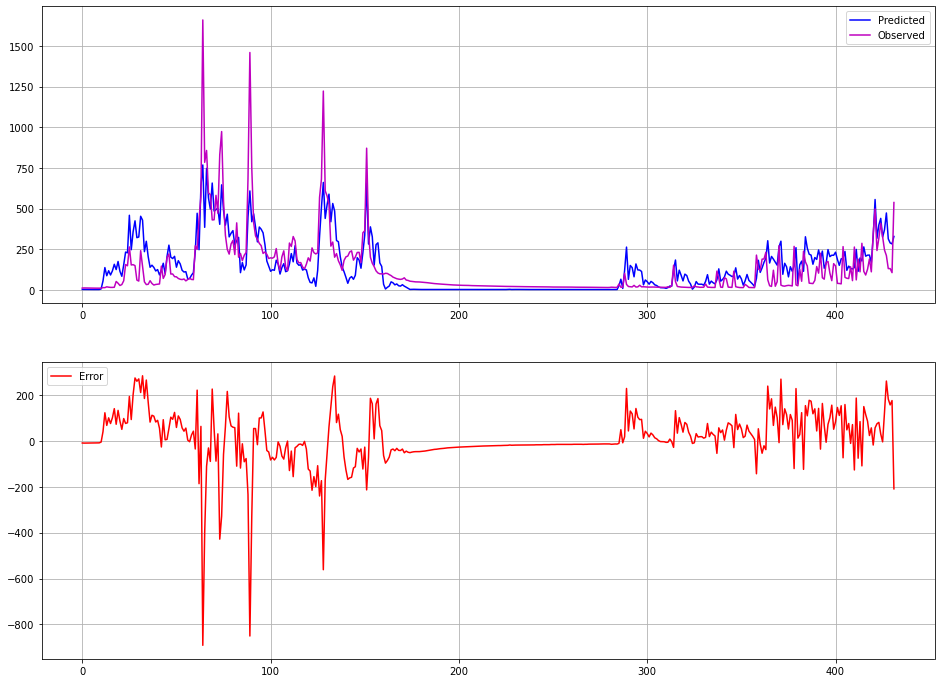

In [275]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_denorm,'b', label = "Predicted")

plt.plot(Y_obser_denorm , 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_denorm - Y_obser_denorm ,'r', label = "Error")

plt.legend()

plt.grid()

### NSE after denormalization

In [276]:
nse_d = he.evaluator(he.nse, Y_pred_denorm , Y_obser_denorm  )
print(nse_d)

[0.61945441]


### RMSE after denormalization (in m3/sec)

In [277]:
#### rmse in m3/sec
rmse_d = he.evaluator(he.rmse, Y_pred_denorm, Y_obser_denorm)
print(rmse_d)    ### 

[117.54251046]
